# News topic

## basic code

In [1]:
import tensorflow as tf

In [3]:
epochs = 20
batch_size = 512
lr = 1e-3

In [2]:
import numpy as np
print(np.__version__)

1.16.1


In [4]:
a = tf.keras.datasets.reuters.load_data(num_words=10000)
print(type(a))

<class 'tuple'>


In [6]:
b, c = a
print(type(b), type(c))

<class 'tuple'> <class 'tuple'>


In [7]:
x_train, y_train_cls = b
x_test, y_test_cls = c
print(x_train.shape, y_train_cls.shape, x_test.shape, y_test_cls.shape)

(8982,) (8982,) (2246,) (2246,)


In [8]:
print(type(x_train[0]), type(x_test[0]))

<class 'list'> <class 'list'>


In [9]:
print(y_train_cls.min(), y_test_cls.min())

0 0


In [10]:
print(y_train_cls.max(), y_test_cls.max())

45 45


In [11]:
print(x_train[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [12]:
y_train_cls = y_train_cls.astype(np.int32) #원래 class가 numpy.int32면 굳이 바꿀 필요 없음....
y_test_cls = y_test_cls.astype(np.int32)
word2int = tf.keras.datasets.reuters.get_word_index(path='reuters_word_index.json')
int2word = dict([(value, key) for (key, value) in word2int.items()])
print(x_train.shape, y_train_cls.shape, x_test.shape, y_test_cls.shape)

557056/550378 [==============================] - 0s 1us/step
(8982,) (8982,) (2246,) (2246,)


In [13]:
print(type(y_test_cls[0]))

<class 'numpy.int32'>


In [14]:
print(' '.join([int2word.get(i - 3, '?') for i in x_train[0]])) #-3은 .. 뭘가
print(y_train_cls[0])

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3
3


In [15]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  
    return results
x_train = vectorize_sequences(x_train) 
x_test = vectorize_sequences(x_test) 
print(x_train.shape, y_train_cls.shape, x_test.shape, y_test_cls.shape)

(8982, 10000) (8982,) (2246, 10000) (2246,)


In [16]:
y_train = np.squeeze(np.eye(46)[y_train_cls]).astype(np.int32)
y_test = np.squeeze(np.eye(46)[y_test_cls]).astype(np.int32)
print(x_train.shape, y_train.shape, y_train_cls.shape, x_test.shape, y_test.shape, y_test_cls.shape)

(8982, 10000) (8982, 46) (8982,) (2246, 10000) (2246, 46) (2246,)


In [17]:
tf.reset_default_graph()
tf.set_random_seed(0)
np.random.seed(0)

In [18]:
x = tf.placeholder(tf.float32, (None, 10000)) 
y = tf.placeholder(tf.int32, (None, 46)) 
y_cls = tf.placeholder(tf.int32, (None,)) 

init_b = tf.keras.initializers.constant(0.0)
init_w = tf.keras.initializers.VarianceScaling(mode='fan_avg')

b1 = tf.get_variable('b1', (64,), tf.float32, init_b)
w1 = tf.get_variable('w1', (10000,64), tf.float32, init_w)

b2 = tf.get_variable('b2', (64,), tf.float32, init_b)
w2 = tf.get_variable('w2', (64,64), tf.float32, init_w)

b3 = tf.get_variable('b3', (46,), tf.float32, init_b)
w3 = tf.get_variable('w3', (64,46), tf.float32, init_w) #1이 아니라 46!

x1 = tf.nn.relu(x @ w1 + b1) 
x2 = tf.nn.relu(x1 @ w2 + b2) 
logits = x2 @ w3 + b3
y_pred_cls = tf.cast(tf.argmax(logits, axis=1), tf.int32, name='y_pred_cls') 

entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=logits) #sigmoid가 아닌 softmax! 
loss = tf.reduce_mean(entropy) 
train = tf.train.RMSPropOptimizer(lr).minimize(loss)

correct = tf.nn.in_top_k(logits, y_cls, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [19]:
def shuffle_batch(x, y, y_cls, batch_size):
    rnd_idx = np.random.permutation(len(x))
    n_batches = len(x) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        yield x[batch_idx], y[batch_idx], y_cls[batch_idx]

In [20]:
with tf.Session() as sess:
    init.run()
    #saver.restore(sess, 'save/nn.ckpt')
    
    loss_trace = []
    accuracy_trace = []

    for i in range(epochs):
        print()
        print('epoch {}/{}'.format(i, epochs), end=' ')
        for x_batch, y_batch, y_batch_cls in shuffle_batch(x_train, y_train, y_train_cls, batch_size):
            feed_dict = {x: x_batch, y: y_batch, y_cls: y_batch_cls}
            loss_run, accuracy_run, _ = sess.run([loss, accuracy, train], feed_dict=feed_dict)
            loss_trace.append(loss_run)
            accuracy_trace.append(accuracy_run)

    feed_dict = {x: x_test, y: y_test, y_cls: y_test_cls}
    accuracy_run, y_test_pred_cls = sess.run([accuracy, y_pred_cls], feed_dict=feed_dict)
    
    saver.save(sess, 'save/nn.ckpt')


epoch 0/20 
epoch 1/20 
epoch 2/20 
epoch 3/20 
epoch 4/20 
epoch 5/20 
epoch 6/20 
epoch 7/20 
epoch 8/20 
epoch 9/20 
epoch 10/20 
epoch 11/20 
epoch 12/20 
epoch 13/20 
epoch 14/20 
epoch 15/20 
epoch 16/20 
epoch 17/20 
epoch 18/20 
epoch 19/20 

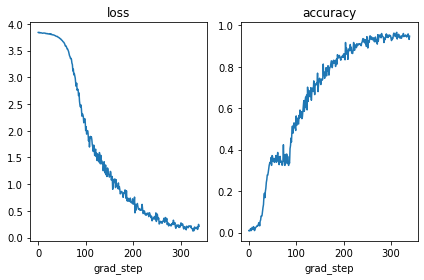

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(loss_trace)
ax2.plot(accuracy_trace)
ax1.set_title('loss')
ax2.set_title('accuracy')
ax1.set_xlabel('grad_step')
ax2.set_xlabel('grad_step')
plt.tight_layout()
plt.show()

In [22]:
print('Test Accuracy :', accuracy_run)

Test Accuracy : 0.7960819


## keras code

In [23]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = y_train[:1000]
partial_y_train = y_train[1000:]

In [26]:
tf.reset_default_graph()
tf.set_random_seed(0)
np.random.seed(0)

In [27]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 175us/step - loss: 2.6758 - accuracy: 0.5303 - val_loss: 1.7202 - val_accuracy: 0.6420
Epoch 2/20
7982/7982 [==============================] - 1s 132us/step - loss: 1.4102 - accuracy: 0.7116 - val_loss: 1.2942 - val_accuracy: 0.7220
Epoch 3/20
7982/7982 [==============================] - 1s 163us/step - loss: 1.0431 - accuracy: 0.7835 - val_loss: 1.1339 - val_accuracy: 0.7560
Epoch 4/20
7982/7982 [==============================] - 1s 139us/step - loss: 0.8186 - accuracy: 0.8330 - val_loss: 1.0357 - val_accuracy: 0.7970
Epoch 5/20
7982/7982 [==============================] - 1s 123us/step - loss: 0.6563 - accuracy: 0.8654 - val_loss: 0.9863 - val_accuracy: 0.7860
Epoch 6/20
7982/7982 [==============================] - 1s 126us/step - loss: 0.5263 - accuracy: 0.8905 - val_loss: 0.9716 - val_accuracy: 0.7800
Epoch 7/20
7982/7982 [==============================] - 1s 123us/step - los

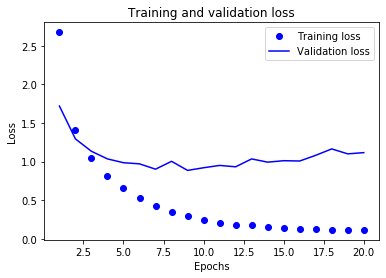

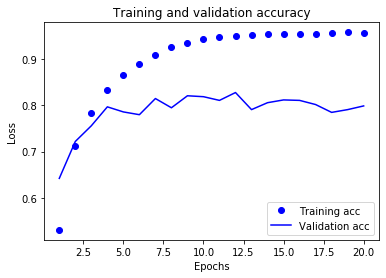

In [28]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # clear figure
acc_values = history.history['accuracy']
val_acc_values = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [29]:
results = model.evaluate(x_test, y_test)
print(results)

2246/2246 [==============================] - 0s 185us/step
[1.2555133411105148, 0.7831701040267944]


In [30]:
model.predict(x_test)

array([[1.8215474e-05, 1.5119128e-05, 5.8332614e-07, ..., 5.3792047e-07,
        3.9588869e-07, 2.1432360e-08],
       [3.2197134e-04, 8.2894890e-03, 1.6050844e-05, ..., 9.8438313e-10,
        1.8186946e-09, 2.4153053e-09],
       [1.0993289e-03, 9.7944105e-01, 2.4316695e-03, ..., 1.1198513e-06,
        4.2236475e-06, 1.3975518e-04],
       ...,
       [1.2019016e-06, 5.0587951e-06, 9.3454690e-07, ..., 5.9509759e-08,
        4.5447052e-08, 4.6836249e-08],
       [2.1075420e-03, 2.5100109e-01, 1.2006557e-03, ..., 4.7779671e-04,
        4.0582908e-04, 5.2556436e-05],
       [9.0819900e-05, 9.8375779e-01, 1.1312205e-03, ..., 5.7833557e-07,
        1.2069136e-06, 1.6650380e-05]], dtype=float32)

## Mix

In [31]:
tf.reset_default_graph()
tf.set_random_seed(0)
np.random.seed(0)

In [32]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation=None))

x = model.input
y = tf.placeholder(tf.int32, (None, 46)) 
y_cls = tf.placeholder(tf.int32, (None,)) 
 
logits = model.output
y_pred_cls = tf.cast(tf.argmax(logits, axis=1), tf.int32, name='y_pred_cls') 

entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=logits) 
loss = tf.reduce_mean(entropy) 
train = tf.train.RMSPropOptimizer(lr).minimize(loss)

correct = tf.nn.in_top_k(logits, y_cls, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

이하는 basic code와 같음...

accuracy도 basic code랑 같은 듯

# House price

In [31]:
import numpy as np

x_train = np.array([848, 960, 1563, 910, 1440, 1944, 904, 936, 912]).reshape((-1,1)).astype(np.float32)
y_train = np.array([272, 313, 342, 325, 291, 351, 294, 367, 279]).reshape((-1,1)).astype(np.float32)
x_train = (x_train - x_train.mean()) / x_train.std()

x_test = np.array([1650]).reshape((-1,1)).astype(np.float32)
y_test = np.array([335]).reshape((-1,1)).astype(np.float32)
x_test = (x_train - x_test.mean()) / x_test.std()

C:\Users\sarah\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


In [32]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(9, 1) (9, 1) (9, 1) (1, 1)


In [33]:
lr = 5e-3
epoch = int(1e3)

In [34]:
import tensorflow as tf
tf.reset_default_graph()

x = tf.placeholder(tf.float32, (None, 1))
y = tf.placeholder(tf.float32, (None, 1))

init_b = tf.keras.initializers.constant(0.0)
init_w = tf.keras.initializers.VarianceScaling(mode='fan_avg')

b = tf.get_variable('b', (1,), tf.float32, init_b)
w = tf.get_variable('w', (1,1), tf.float32, init_w)

y_pred = x @ w + b
error = y - y_pred
loss = tf.nn.l2_loss(error)
train = tf.train.RMSPropOptimizer(lr).minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

with tf.Session() as sess :
    sess.run(init)
    
    loss_trace = []
    for i in range(epoch) :
        feed_dict = {x:x_train, y:y_train}
        if i % 100 == 99 :            
            _, loss_run = sess.run([train, loss], feed_dict=feed_dict)
            loss_trace.append(loss_run)
        else :
            sess.run(train, feed_dict=feed_dict)

    feed_dict = {x:x_train}
    y_train_pred = sess.run(y_pred, feed_dict=feed_dict)

    feed_dict = {x:x_test}
    y_test_pred_final = sess.run(y_pred, feed_dict = feed_dict)

plt.plot(loss_trace)
plt.show()

plt.plot(x_train, y_train, 'ob')
plt.plot(x_train, y_train_pred, '-b')
plt.plot(x_test, y_test, 'ob')
plt.plot(x_test, y_test, 'or')
plt.show()


KeyboardInterrupt: 